## Dubendorf Meeting (16.02.2026)

Discussion on water samples for gas and water age analyses.  The aim is to investigate horizontal exchange as a potential pathway for deep water renewal.

Lake Zug is stratified throughout the year, has not fully mixed in over a decade.  Typically anoxic below 100m, 

Mechanisms:
- Wind/cooling events bring shallower, younger water to depth.  If co-occurence with an inter-basin flow (i.e., internal seiche), more shallower water can be brought to depth than just the overlying water.
- Increased mixing at depth in the constriction can create density gradients between the constriction and basin mouths the can promote density currents.



In [1]:
# imports
import ewgreaders as ewg
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
from glob import glob

In [2]:
# Lake Zug bathymetry
bathy = xr.open_dataset('Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/bathymetry.nc')

In [6]:
ws_locs = pd.DataFrame({
    'loc': ['WSS', 'WSC', 'WSN'],
    'xsc': [680442, 680105, 679250],
    'ysc': [216834, 218781, 220350]
})

ws_locs['xsc'] += int(2e6)
ws_locs['ysc'] += int(1e6)

ws_locs['total_depth'] = [bathy.sel(xsc=row.xsc, ysc=row.ysc).depth.item() for _, row in ws_locs.iterrows()]

ws_locs

,loc,xsc,ysc,total_depth
0,WSS,2680442,1216834,200.63000
1,WSC,2680105,1218781,177.31001
2,WSN,2679250,1220350,121.14001


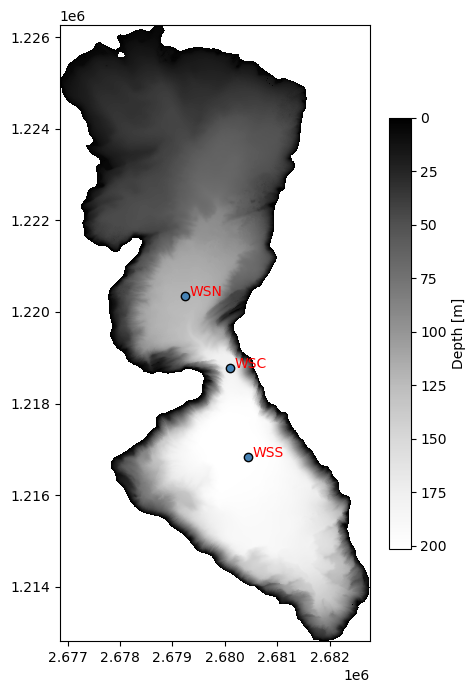

In [7]:
fig, ax = plt.subplots(figsize=(5, 8))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

# water sample locations
for _, row in ws_locs.iterrows():
    ax.scatter(row.xsc, row.ysc, c='steelblue', edgecolor='black')
    ax.annotate(row['loc'], (row.xsc, row.ysc), color='red', xytext=(3, 0), textcoords='offset points')

plt.show()

In [8]:
# angle between WSN and WSC (wrt 0 degrees at x-axis)
x_wsc, y_wsc = ws_locs.query("loc == 'WSC'").iloc[0][['xsc', 'ysc']]
x_wsn, y_wsn = ws_locs.query("loc == 'WSN'").iloc[0][['xsc', 'ysc']]
x_wss, y_wss = ws_locs.query("loc == 'WSS'").iloc[0][['xsc', 'ysc']]

In [9]:
def angle_btwn_points(x1, y1, x2, y2):
    """
    Calculate angle between two points with respect to 0 degrees defined as x-axis.
    """
    theta_rad = np.arctan2(y2-y1, x2-x1)
    
    return np.degrees(theta_rad)

def distance_btwn_points(x1, y1, x2, y2):
    """
    Calculate distance between two points.
    """
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [10]:
theta_cn = angle_btwn_points(x_wsc, y_wsc, x_wsn, y_wsn)
theta_cs = angle_btwn_points(x_wsc, y_wsc, x_wss, y_wss)
theta_cn, theta_cs

(np.float64(118.58742773118286), np.float64(-80.18014990374417))

In [11]:
dist_cn = distance_btwn_points(x_wsc, y_wsc, x_wsn, y_wsn)
dist_cs = distance_btwn_points(x_wsc, y_wsc, x_wss, y_wss)
dist_cn, dist_cs

(np.float64(1786.8368700024073), np.float64(1975.9498981502543))

### Current Work

In [22]:
def valid_depths(ds, thresh):
    """
    Filter depths below threshold of non-nan values.

    Parameters
    ----------
    ds : xr.DataArray
        Data with a depth or range dimension and a time dimension.
    thresh : float
        Threshold for fraction (0–1) of non-nan values.

    Returns
    -------
    xr.DataArray
        Filtered data with only valid depths/ranges.
    """

    # Fraction of valid (non-NaN) data over time
    valid_fraction = ds.notnull().mean(dim='time')

    # ADCP data
    if 'range' in ds.dims:
        ds = ds.where(valid_fraction >= thresh, drop=True)

    # Thermistor / oxygen logger data
    elif 'depth' in ds.dims:
        ds = ds.where(valid_fraction >= thresh, drop=True)

    else:
        raise ValueError("No 'range' or 'depth' dimension found.")

    return ds

#### Daily net flux across constriction in anoxic region

In [23]:
def plot_daily_volume_transport(df_avg):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.axvline(0, color='black', linestyle='--')
    sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

    ax.set_xlabel('Daily Volume Transport [m^3]')
    ax.set_ylabel('Depth [m]')

    ax.invert_yaxis()
    ax.spines[['right', 'top']].set_visible(False)
    plt.show()

In [28]:
lake = 'Zugersee'
location = 'LZC'
year = '2026'
date = '20260114'

mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
t_start = pd.to_datetime(mreader.md['deployment'], format='%d.%m.%Y') + pd.Timedelta(days=1)
t_end = pd.to_datetime(mreader.md['retrieval'], format='%d.%m.%Y') - pd.Timedelta(days=1)
mxsc, mysc = mreader.get_swiss_coords()
adcps = mreader.get_adcps()
oxygen_loggers = mreader.get_oxygen_loggers()
adcps

[{'instrument': 'adcp', 'serial_id': '8315', 'mab': 123, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '672', 'mab': 98, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '1728', 'mab': 98, 'comments': 'down'},
 {'instrument': 'adcp', 'serial_id': '16549', 'mab': 41.4, 'comments': 'up'}]

In [15]:
# deepest ADCP
serial_id = '16549'

areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)
print(areader.depth, ds.attrs['cell_size'])
ds = ds.sel(time=slice(t_start, t_end))

# only maintain depths with 99% valid data
ds = valid_depths(ds, 0.99)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...
131.96441650390625 1.0


In [30]:
flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.volume_flux(ds, d, mxsc, mysc, theta_cs+90, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [31]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

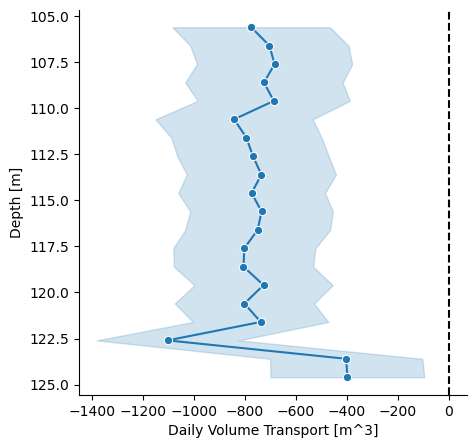

In [32]:
plot_daily_volume_transport(df_avg)

#### Excursion length in anoxic region

In [34]:
# excursion lenghts to N
eln_data = []
for d in tqdm(ds.range.values):
    el = ewg.lakes.excursion_length(ds, d, theta_cn-90)
    eln_data.append(el)

df_eln = pd.concat(eln_data, ignore_index=True)

# maximum excursion length at each depth
df_eln_max = df_eln.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
# excursion lenghts to S
els_data = []
for d in tqdm(ds.range.values):
    el = ewg.lakes.excursion_length(ds, d, theta_cs+90)
    els_data.append(el)

df_els = pd.concat(els_data, ignore_index=True)

# maximum excursion length at each depth
df_els_max = df_els.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

  0%|          | 0/20 [00:00<?, ?it/s]

In [36]:
# select each direction for its respective angle
df_el_max = pd.concat([df_eln_max.query("direction == 'N'"), df_els_max.query("direction == 'S'")])

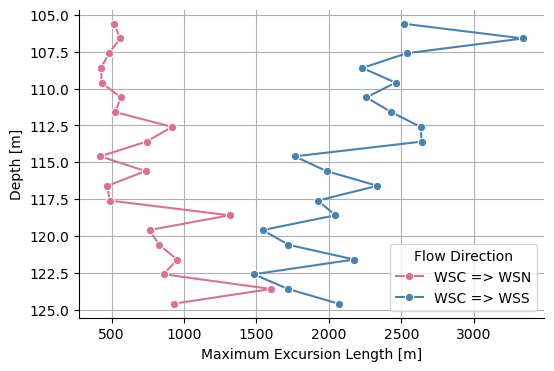

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
palette = ['palevioletred', 'steelblue']

sns.lineplot(df_el_max, x='excursion_length', y='depth', orient='y', 
             hue='direction', hue_order=['N', 'S'], palette=palette, marker='o', ax=ax)

ax.set_xlabel('Maximum Excursion Length [m]')
ax.set_ylabel('Depth [m]')

ax.spines[['right', 'top']].set_visible(False)
ax.invert_yaxis()

labels = ["WSC => WSN", "WSC => WSS"]
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Flow Direction')
ax.grid(True)
plt.show()

#### Progressive vector diagram

Following downwelling of oxygen.

In [40]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.fpath = fpath
    oreader.sensor = oreader.get_sensor_type()
    oreader.mab = oreader.get_mab()
    oreader.depth = oreader.set_depth()

    dso = oreader.load_from_L0()
    dso = dso.sel(time=slice(t_start, t_end))
    dso['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(dso)

ds_do = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


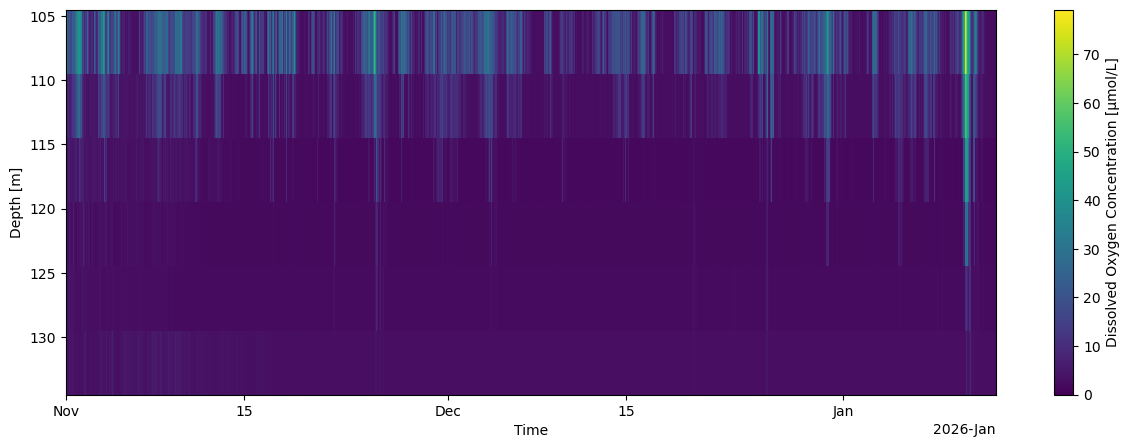

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

ax.invert_yaxis()
plt.show()

In [42]:
# time of maximum oxygen at depth
d = 120
ds_do_sel = ds_do.sel(depth=d, method='nearest')
idx = ds_do_sel.d_oxygen_conc.argmax()
t0 = ds_do_sel.d_oxygen_conc[idx].time.values
t0

np.datetime64('2026-01-10T15:39:00.000000000')

In [43]:
# velocity timeseries following oxygen downwelling
d = ds_do_sel.depth.item()
u = ds.vel.sel(dir='E').sel(range=d, method='nearest').sel(time=slice(t0, None))
v = ds.vel.sel(dir='N').sel(range=d, method='nearest').sel(time=slice(t0, None))
w = ds.vel.sel(dir='U').sel(range=d, method='nearest').sel(time=slice(t0, None))

In [44]:
dt = ds.time.diff('time').astype('timedelta64[s]').astype(float)
dt = dt.reindex(time=ds.time, method='pad')

# project onto line from WSC to WSS
angle_rad = np.deg2rad(theta_cs+90)
u_orth = u * (-1) * np.sin(angle_rad)
v_orth = v * np.cos(angle_rad)

r = ((u_orth + v_orth) * dt).cumsum('time')

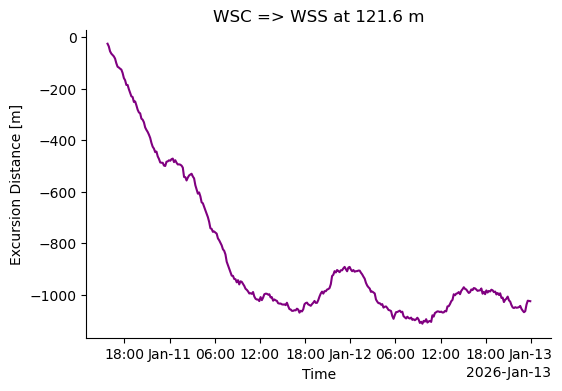

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))

r.plot(color='purple', ax=ax)

ax.set_xlabel('Time')
ax.set_ylabel('Excursion Distance [m]')
ax.set_title(f'WSC => WSS at {r.range.item()} m')

ax.spines[['right', 'top']].set_visible(False)

plt.show()

### Anoxic depth in S basin

Load all CTD profiles.  Condition on ysc (S basin) or closeness to WSS (with X m radius) and calculate anoxic depth.

In [40]:
def calculate_transect_min_do(dpath_L1):
    # transect minimum
    min_do = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        do = ds['DO_mg'][mask]
        min_do.append(do.min().item())

    return min(min_do)

In [55]:
'20251030' > '20250915'

True

In [59]:
years = ['2025', '2026']
anoxia_data = []
for year in years:
    ctd_root = f'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/{year}/CTD'

    for date in tqdm(os.listdir(ctd_root)):
        if date > '20250915':
            dpath_L1 = os.path.join(ctd_root, date, 'L1')
            for p in os.listdir(dpath_L1):
                fpath = os.path.join(dpath_L1, p)
                ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
                ds = ctdreader.load_from_L1()

                # Swiss coordinates
                xsc = int(ds.attrs['X Coordinate (CH1903)']) + int(2e6)
                ysc = int(ds.attrs['Y Coordinate (CH1903)']) + int(1e6)

                dist = distance_btwn_points(x_wss, y_wss, xsc, ysc)
                if dist < 500 or ysc < y_wss:
                    min_do = calculate_transect_min_do(dpath_L1)
                    
                    # data quality
                    mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
                    depth = ds['depth'][mask]
                    do = ds['DO_mg'][mask]

                    try:
                        idx = np.where(do <= min_do + 0.2)[0][0]
                        z = depth[idx].item()
                    except IndexError:
                        z = np.nan

                    anoxia_data.append({
                        'date': pd.to_datetime(date, format='%Y%m%d'),
                        'anoxic_depth': z
                    })

anoxia_data = pd.DataFrame(anoxia_data)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

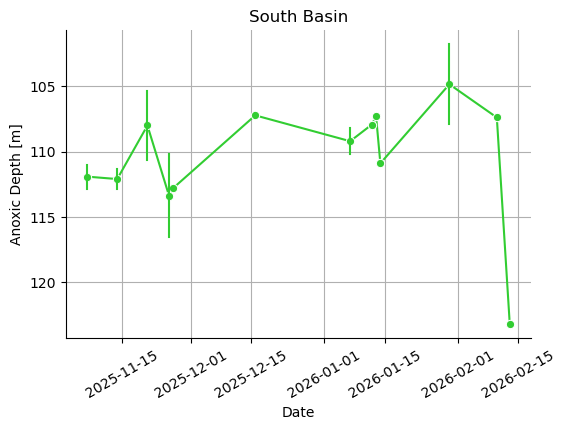

In [76]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(anoxia_data, x='date', y='anoxic_depth', marker='o', errorbar=('se', 1), err_style='bars', color='limegreen', ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Anoxic Depth [m]')
ax.set_title('South Basin')
ax.tick_params(axis='x', rotation=30)

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
ax.grid(True)
plt.show()

#### Salinity dominating stratification

Plot temperature and density for CTD profiles with large overturnings in temperature but none in density.

In [77]:
def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        else:
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        if var == 'DO_mg':    # convert to umol/L
            vals *= (1000/32)

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)

In [78]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260205'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

In [79]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
rho_data = extract_data_vars(dpath_L1, 'rho')
rho_sg = ewg.signal.savitzky_golay(rho_data['rho'])
rho_ra = ewg.signal.rolling_average(rho_data['rho'], rho_data['depth'], 0.5)

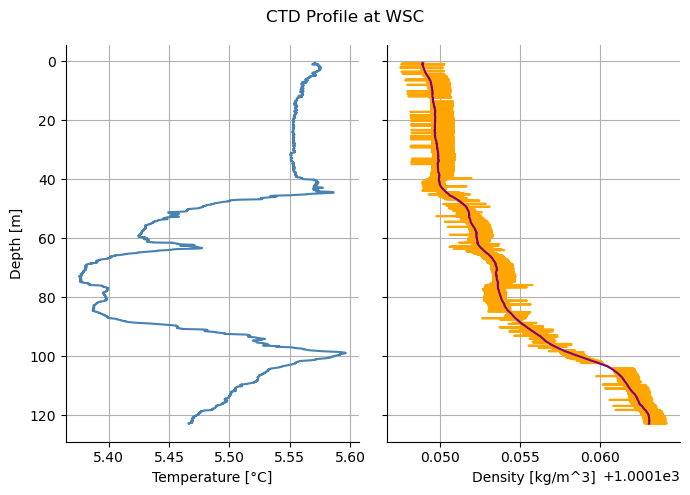

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 5), sharey=True)

ax[0].plot(temp_data['Temp'], temp_data['depth'], color='steelblue')
ax[1].plot(rho_data['rho'], rho_data['depth'], color='orange')
ax[1].plot(rho_sg, rho_data['depth'], color='purple')
#ax[2].plot(rho_ra, rho_data['depth'], color='black')

ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature [°C]')
ax[1].set_xlabel('Density [kg/m^3]')
plt.suptitle('CTD Profile at WSC')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].grid(True)
ax[1].grid(True)
ax[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### Conductivity Isolines

In [28]:
def calculate_isolines(dpath_L1, var, isovals, smooth=False, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'Temp' or var == 'Cond':
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        elif var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask] 

        # smooth profile
        if smooth:
            vals = ewg.signal.savitzky_golay(vals)

        for iv in isovals:
            try:
                if var == 'Temp':
                    idxl = np.where(vals < iv)[0][0]
                    idxu = np.where(vals > iv)[0][-1]
                elif var == 'rho' or var == 'Cond':
                    idxl = np.where(vals > iv)[0][0]
                    idxu = np.where(vals < iv)[0][-1]

                idx = round((idxl + idxu)/2)
                z = depth[idx].item()
            except IndexError:
                z = np.nan

            data.append({
                'var': var,
                'iso_val': iv,
                'iso_z': z,
                'name': name,
                'time': time,
                'xsc': xsc,
                'ysc': ysc,
                'total_depth': total_depth
            })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)

def plot_isolines(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))
    order = np.sort(df['iso_val'].unique())
    if var == 'Temp':
        palette = sns.color_palette('Blues_d', n_colors=len(order))[::-1]
    elif var == 'rho':
        palette = sns.color_palette('Oranges_d', n_colors=len(order))
    elif var == 'Cond':
        palette = sns.color_palette('Purples_d', n_colors=len(order))

    sns.lineplot(df, x='ysc', y='iso_z', hue='iso_val', hue_order=order, palette=palette, marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)

    if var == 'Temp':
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Temperature [°C]')
    elif var == 'rho':
        ax.legend(title='Density [kg/m3]')
    elif var == 'Cond':
        ax.legend(title='Conductivty [mS/cm]')
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

In [50]:
def default_salinity_temperature(temperature):
    return 1.8626 - 0.052908 * temperature + 0.00093057 * temperature ** 2 - 6.78e-6 * temperature ** 3

def cond20_conversion(temp, cond):
    ft = default_salinity_temperature(temp)
    cond20 = ft * cond * 1000
    return cond20

In [51]:
# 7.1.2026
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260107'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

In [80]:
depths = np.arange(80, 200, 10)
depths

array([ 80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190])

In [85]:
data = []
for p in os.listdir(dpath_L1):
    fpath = os.path.join(dpath_L1, p)
    
    ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
    bathy = ctdreader.load_bathymetry()
    ds = ctdreader.load_from_L1()

    # metadata
    name = ds.attrs['Profile name']
    time = ds.attrs['Time of measurement (local)']
    xsc = int(ds.attrs['X Coordinate (CH1903)'])
    ysc = int(ds.attrs['Y Coordinate (CH1903)'])

    mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
    depth = ds['depth'][mask]
    temp = ds['Temp'][mask]
    cond = ds['Cond'][mask]
    salin = ds['SALIN'][mask]

    for d in depths:
        idx = np.abs(depth - d).argmin(dim='time').item()

        # only if profile has target depth
        if np.abs(depth[idx].item() - d) < 1:
            data.append({
                'name': name,
                'time': time,
                'xsc': xsc,
                'ysc': ysc,
                'target_depth': d,
                'depth': depth[idx].item(),
                'cond': cond[idx].item(),
                'salin': salin[idx].item()
            })

data = pd.DataFrame(data)

In [86]:
data

,name,time,xsc,ysc,target_depth,depth,cond,salin
0,P05',12:22,679322,219531,80,80.006007,0.1840,0.255793
1,P05',12:22,679322,219531,90,89.999697,0.1852,0.257849
2,P05',12:22,679322,219531,100,99.988344,0.1864,0.259889
3,P05',12:22,679322,219531,110,109.999957,0.1864,0.260388
4,P05',12:22,679322,219531,120,119.994509,0.1864,0.260688
...,...,...,...,...,...,...,...,...
104,P03,11:58,679667,221633,90,89.991576,0.1876,0.261838
105,P04,12:09,679420,220428,80,80.011413,0.1852,0.257256
106,P04,12:09,679420,220428,90,90.001296,0.1876,0.261240
107,P04,12:09,679420,220428,100,99.979141,0.1876,0.261591


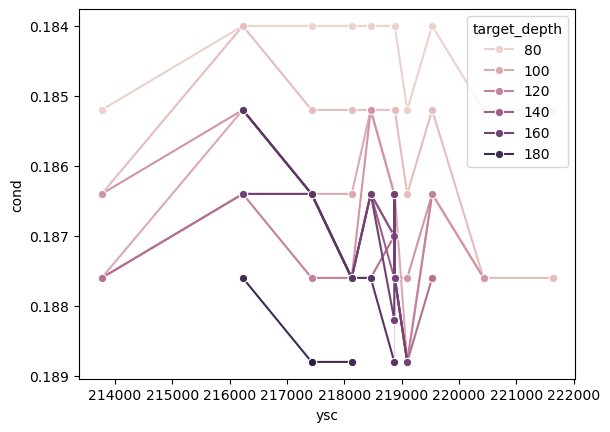

In [87]:
fig, ax = plt.subplots()

sns.lineplot(data, x='ysc', y='cond', hue='target_depth', marker='o', ax=ax)

ax.invert_yaxis()
plt.show()

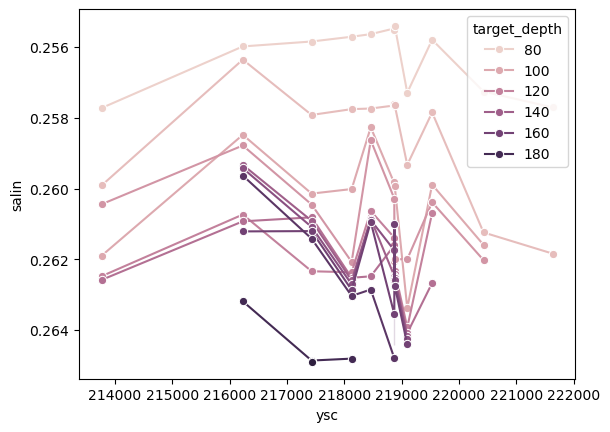

In [88]:
fig, ax = plt.subplots()

sns.lineplot(data, x='ysc', y='salin', hue='target_depth', marker='o', ax=ax)

ax.invert_yaxis()
plt.show()

In [ ]:
target = 100

idx = np.abs(depth - target).argmin(dim='time').item()
idxa

2683

In [66]:
depth[idx].item()

99.97914116941432

In [64]:
cond[idx].item()

0.1876

In [65]:
salin[idx].item()

0.2615910692921935

In [56]:
idx = np.where(depth==100)
idx

(array([], dtype=int64),)

In [57]:
depth.sel(depth=100, method='nearest')

KeyError: "'depth' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'time': 3485})"

In [53]:
cond

<xarray.DataArray 'Cond' (time: 3485)> Size: 28kB
[3485 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 28kB 2026-01-07T11:09:03 ... 2026-01-07T11...
Attributes:
    units:      mS/cm
    long_name:  conductivity

In [54]:
cond20

<xarray.DataArray (time: 3485)> Size: 28kB
array([276.62037153, 278.46199456, 278.44850467, ..., 300.12274255,
       300.11786522, 300.11786522], shape=(3485,))
Coordinates:
  * time     (time) datetime64[ns] 28kB 2026-01-07T11:09:03 ... 2026-01-07T11...

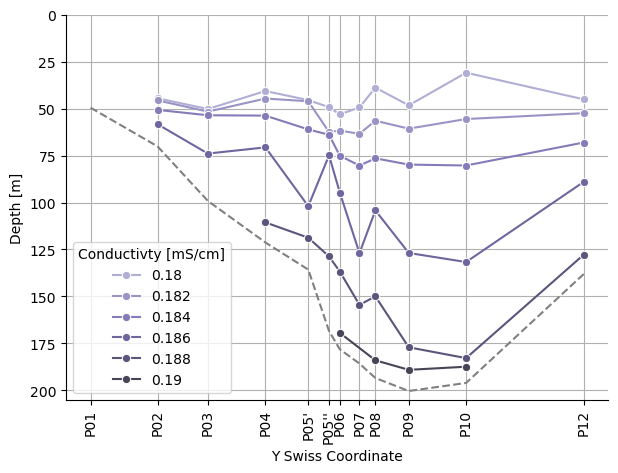

In [27]:
isocond_data = calculate_isolines(dpath_L1, 'Cond', np.arange(0.18, 0.19, 0.002))
plot_isolines(isocond_data, 'Cond', t_start='11:30')

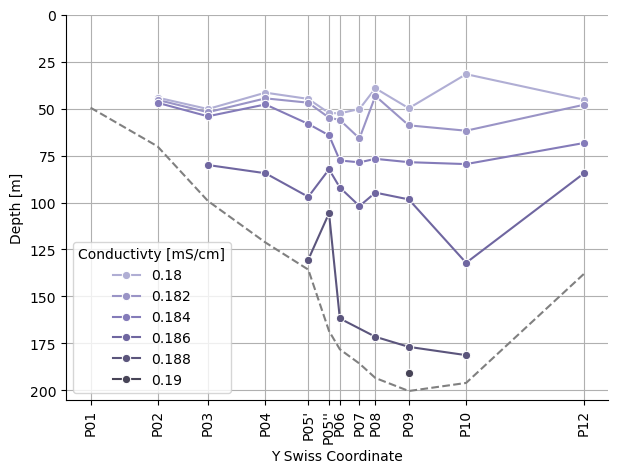

In [30]:
isocond_data = calculate_isolines(dpath_L1, 'Cond', np.arange(0.18, 0.19, 0.002), smooth=True)
plot_isolines(isocond_data, 'Cond', t_start='11:30')

In [34]:
# 28.1.2026
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260128'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

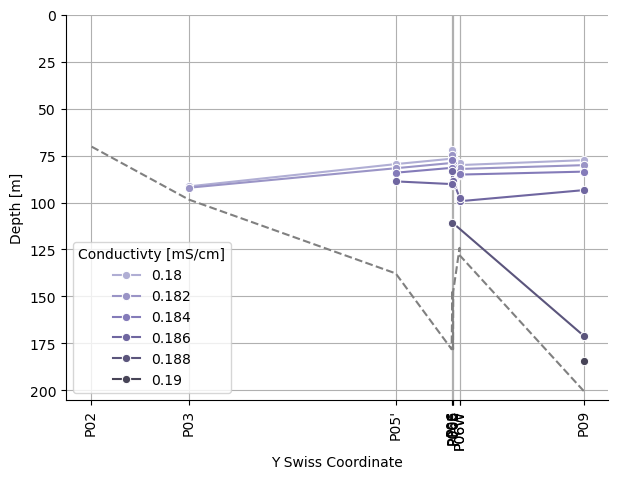

In [37]:
isocond_data = calculate_isolines(dpath_L1, 'Cond', np.arange(0.18, 0.19, 0.002), smooth=True)
plot_isolines(isocond_data, 'Cond')

In [ ]:
# 10.2.2026
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260210'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

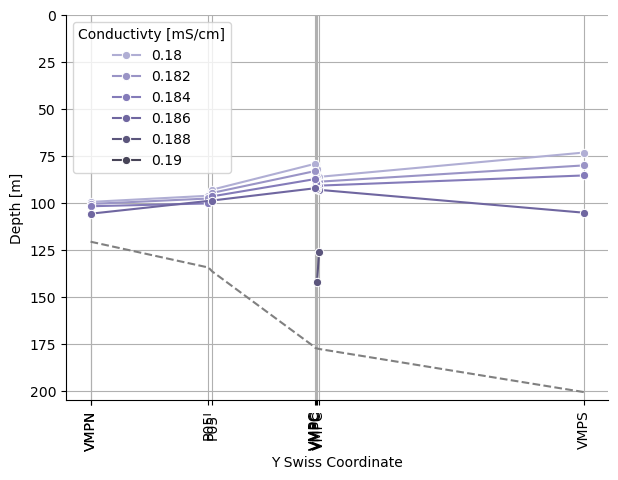

In [39]:
isocond_data = calculate_isolines(dpath_L1, 'Cond', np.arange(0.18, 0.19, 0.002), smooth=True)
plot_isolines(isocond_data, 'Cond')

In [40]:
# 13.2.2026
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260213'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

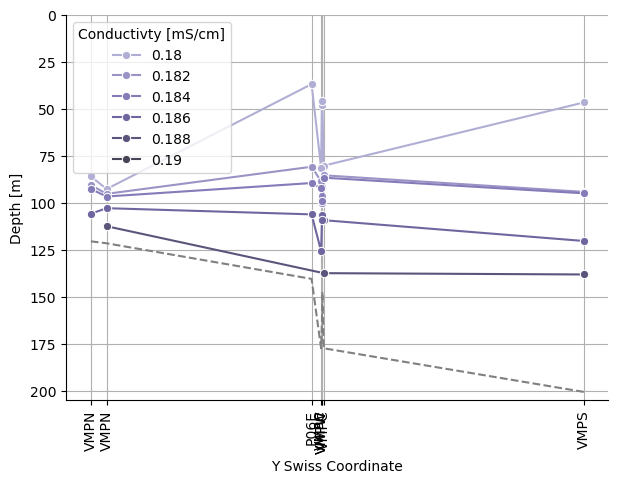

In [42]:
isocond_data = calculate_isolines(dpath_L1, 'Cond', np.arange(0.18, 0.19, 0.002), smooth=False)
plot_isolines(isocond_data, 'Cond')

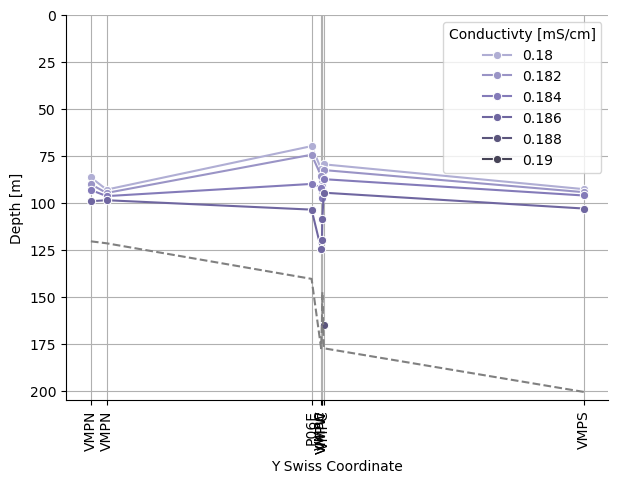

In [41]:
isocond_data = calculate_isolines(dpath_L1, 'Cond', np.arange(0.18, 0.19, 0.002), smooth=True)
plot_isolines(isocond_data, 'Cond')